## Домашнее задание

Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками. Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote. **Внесла изменения только в ф-цию визуализации**

Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

In [2]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = make_classification(n_samples=1000,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=26)

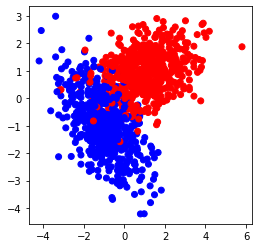

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(4,4))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

**ИЗМЕНЕНИЯ в функции get_bootstrap**

In [4]:
np.random.seed(26)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    oob = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        #индексы сэмпла превращаем во множество и вычитаем из множества всех индексов
        oob_index = list(set(range(0,n_samples))-set(sample_index))
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        #формируем OOB сэмпл из оставшихся индексов
        oob_data = data[oob_index]
        oob_label = labels[oob_index]
        
        bootstrap.append((b_data, b_labels))
        oob.append((oob_data, oob_label))
        
    return bootstrap, oob

In [5]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.round(np.sqrt(len_sample)))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction   

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
#     min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

**ИЗМЕНЕНИЯ**

In [14]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
#ИЗМЕНЕНИЕ  адаптируем ф-цию под возможность предсказания по одному дереву
    if type(forest) == Node:
        predictions.append(predict(data, forest))
    else:
        for tree in forest:
            predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))

        
    return voted_predictions

In [15]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

**ИЗМЕНЕНИЯ в функции random_forest**

In [16]:
def random_forest(data, labels, n_trees):
#     строим лес как обычно
    forest = []
    bootstrap, oob = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
#ИЗМЕНЕНИЯ каждую неиспользованную выбоорку тестим на дереве, которое её не использовало при обучении    
    accuracy = []
    for i in range(len(oob)):
        pred = tree_vote(forest[i], oob[i][0])
        accuracy.append(accuracy_metric(oob[i][1], pred))
    mean_acc = round(np.array(accuracy).mean(),3)
    max_acc = round(np.array(accuracy).max(),3)
    print(f'N of trees: {n_trees}   Accuracy (OOB estimated): mean={mean_acc}  max={max_acc}')
        
    return forest

In [17]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [18]:
forest_1 = random_forest(classification_data, classification_labels, 1)
forest_3 = random_forest(classification_data, classification_labels, 3)
forest_5 = random_forest(classification_data, classification_labels, 5)
forest_10 = random_forest(classification_data, classification_labels, 10)
forest_50 = random_forest(classification_data, classification_labels, 50)

N of trees: 1   Accuracy (OOB estimated): mean=91.209  max=91.209
N of trees: 3   Accuracy (OOB estimated): mean=88.378  max=91.512
N of trees: 5   Accuracy (OOB estimated): mean=90.293  max=92.371
N of trees: 10   Accuracy (OOB estimated): mean=91.159  max=93.243
N of trees: 50   Accuracy (OOB estimated): mean=89.939  max=95.068


**ИЗМЕНЕНИЯ в функции visualize**

In [19]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(data, forest):
    plt.figure(figsize = (15, 5))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(data)
    #вместо predict - tree_vote
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape) 
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
#     plt.scatter(data[:, 0], data[:, 1], c = classification_labels, cmap = colors)
#     plt.title(f'Train accuracy={train_accuracy:.2f}')

**Вывод:**<br>
У модели есть признаки переобучения во всех случаях (какие-то отдельно стоящие полосы, вырезанные квадратики). Но чем больше деревьев, тем менее сглаженные границы между классами и меньше отдельно стоящих областей + они меньше гораздо. Т.е. чем больше деревьев, тем меньше переобучение.

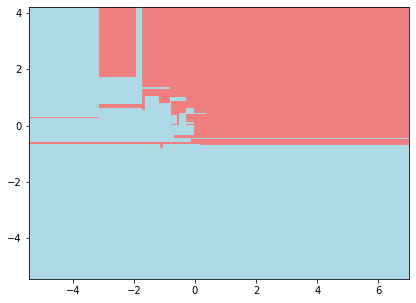

In [20]:
visualize(classification_data, forest_1)

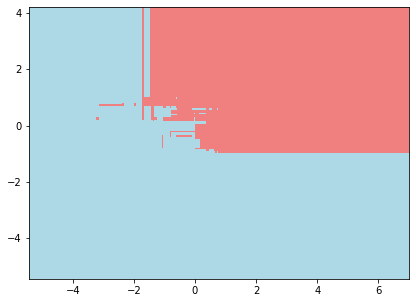

In [21]:
visualize(classification_data, forest_3)

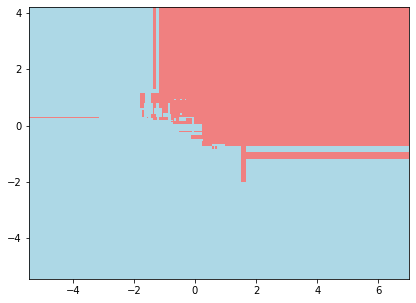

In [22]:
visualize(classification_data, forest_5)

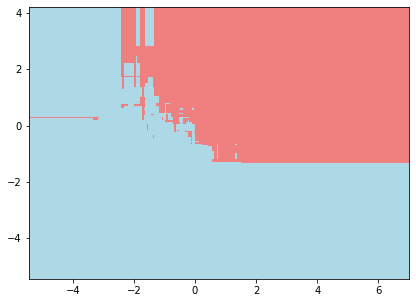

In [23]:
visualize(classification_data, forest_10)

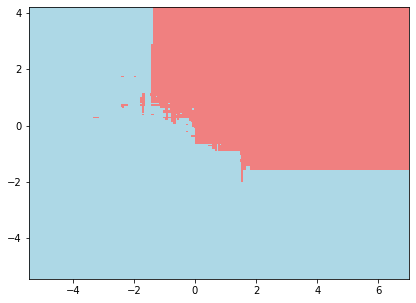

In [24]:
visualize(classification_data, forest_50)

Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее. Оценить ошибку этого же алгоритма по методу Out-of-Bag будет вашим домашним заданием к этому уроку.

In [25]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

Построим лес из одного дерева

In [26]:
%%time
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

N of trees: 1   Accuracy (OOB estimated): mean=88.525  max=88.525
CPU times: total: 297 ms
Wall time: 299 ms


In [27]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [28]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [29]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 96.000
Точность случайного леса из 1 деревьев на тестовой выборке: 91.667


Построим лес из трех деревьев

In [30]:
%%time
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

N of trees: 3   Accuracy (OOB estimated): mean=86.778  max=88.048
CPU times: total: 781 ms
Wall time: 792 ms


In [31]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

In [32]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [33]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 97.571
Точность случайного леса из 3 деревьев на тестовой выборке: 92.000


Построим лес из десяти деревьев

In [34]:
%%time
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

N of trees: 10   Accuracy (OOB estimated): mean=90.102  max=92.188
CPU times: total: 2.64 s
Wall time: 2.64 s


In [35]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

In [36]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [37]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 99.429
Точность случайного леса из 10 деревьев на тестовой выборке: 93.333


Построим лес из пятидесяти деревьев

In [38]:
%%time
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

N of trees: 50   Accuracy (OOB estimated): mean=90.205  max=94.208
CPU times: total: 13.8 s
Wall time: 13.8 s


In [39]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

In [40]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [41]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 99.857
Точность случайного леса из 50 деревьев на тестовой выборке: 94.000
